In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
import os
from sklearn.cluster import KMeans
import re

from Analyse_Events_Functions import *

def find_quintile_with_max_value(intensities):
    
    # Number of elements in each quintile
    quintile_size = len(intensities) // 5
    
    # Calculate the indices that will split the array into quintiles
    quintile_indices = [i * quintile_size for i in range(1, 5)] + [len(intensities)]
    
    # Split the array into quintiles
    quintiles = np.array_split(intensities, 5)
    
    # Find the quintile that contains the maximum value
    max_value = np.max(intensities)
    for i, quintile in enumerate(quintiles):
        if max_value in quintile:
            return i
        
def interpolate_and_bin(normalized_time, normalized_rainfall):
    """
    Interpolate missing data points and bin the dimensionless profile into 12 segments.
    
    Parameters:
        normalized_time (np.array): Normalized time array.
        normalized_rainfall (np.array): Normalized cumulative rainfall array.
    
    Returns:
        np.array: Binned and interpolated rainfall profile.
    """
    # Define target points for 12 bins
    target_points = np.linspace(0, 1, 13)
    
    # Create interpolation function based on existing data points
    interpolation_func = interp1d(normalized_time, normalized_rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values


def check_for_nan(profiles_list, durations_for_nimrod_profiles,volumes_for_nimrod_profiles):
    new_profiles_ls = []
    new_durations_ls = []
    new_volumes_ls = []
    for i, profile in enumerate(profiles_list):
        if np.isnan(profile).any():
            print(f"NaN values found in profile {i}")
        else:
            new_profiles_ls.append(profile)
            new_durations_ls.append(durations_for_nimrod_profiles[i])
            new_volumes_ls.append(volumes_for_nimrod_profiles[i])
    return new_profiles_ls, new_durations_ls, new_volumes_ls

### Define EM to study

In [2]:
em = 'bc009'

# Create a set of dimensionless profiles
Read in all of the events, for all durations, for all gauges, for all ensemble members.  
Convert them to dimensionless profiles, with 12 values between 0 and 1.  
Each value is a dimensionless, cumulative rainfall value (cumulative rainfall at this timestep, normalised by the total event rainfall):
- 0 means no rainfall has occurred, and 
- 1 means the total event rainfall has been reached.  

If there are less than 12 values, then these are filled in with interpolation

### NIMROD

In [3]:
def process_file(gauge_num, file):
    # Read the CSV file
    test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/{file}")
    
    # Find duration from file name
    match = pattern.search(file)
    if match:
        duration = match.group(1)
    else:
        duration = None
    
    precipitation_sum = test['precipitation (mm)'].sum()

    if len(test) == 1:
        print(f"Only 1 value at gauge_num {gauge_num} for {file}")
        return None, None, None
    else:
        times = np.array(range(0, len(test)))
        normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
        interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
        heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)
        return interpolated_rainfall, duration, precipitation_sum

# Pre-compile the regex pattern
pattern = re.compile(r'(\d+\.?\d*)hrs')

# Initialize lists to store results
nimrod_profiles = []
durations_for_nimrod_profiles = []
volumes_for_nimrod_profiles = []

# Process each gauge
gauge_nums =  range(0,1294)
for gauge_num in gauge_nums:
    if gauge_num not in [444, 827, 888]:
        print(gauge_num)
        # Create a list of all the event CSVs
        files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/") if f.endswith('.csv')]
        files = np.sort(files)

        # Process each file
        for file in files:
            interpolated_rainfall, duration, precipitation_sum = process_file(gauge_num, file)
            if interpolated_rainfall is not None and duration is not None and precipitation_sum is not None:
                nimrod_profiles.append(interpolated_rainfall)
                durations_for_nimrod_profiles.append(duration)
                volumes_for_nimrod_profiles.append(precipitation_sum)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
new_nimrod_profiles, new_nimrod_durations, new_nimrod_volumes = check_for_nan(nimrod_profiles,durations_for_nimrod_profiles,volumes_for_nimrod_profiles )

NaN values found in profile 20754
NaN values found in profile 20835
NaN values found in profile 30892
NaN values found in profile 30907
NaN values found in profile 30922
NaN values found in profile 30937
NaN values found in profile 30953
NaN values found in profile 30968
NaN values found in profile 30983
NaN values found in profile 34763
NaN values found in profile 35134
NaN values found in profile 35149
NaN values found in profile 35164
NaN values found in profile 35179
NaN values found in profile 35180
NaN values found in profile 35197
NaN values found in profile 35212
NaN values found in profile 35227
NaN values found in profile 36015
NaN values found in profile 36045
NaN values found in profile 62712


### Select the top 10% of events

In [23]:
# Calculate the cutoff for the top 10%
cutoff = np.percentile(new_nimrod_volumes, 90)

# Get indices of values in the top 10%
top_10_percent_indices = [i for i, x in enumerate(new_nimrod_volumes) if x >= cutoff]

# Extract corresponding values from the other list
top_10_percent_profiles = [new_nimrod_profiles[i] for i in top_10_percent_indices]
top_10_percent_durations = [new_nimrod_durations[i] for i in top_10_percent_indices]

### UKCP18

In [31]:
def process_file(gauge_num, file):
    # Read the CSV file
    test = pd.read_csv(f"../../ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/Option2/EventSet/{file}")
    
    # Find duration from file name
    match = pattern.search(file)
    if match:
        duration = match.group(1)
    else:
        duration = None
    
    precipitation_sum = test['precipitation (mm)'].sum()

    if len(test) == 1:
        print(f"Only 1 value at gauge_num {gauge_num} for {file}")
        return None, None, None
    else:
        times = np.array(range(0, len(test)))
        normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
        interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
        heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)
        real_duration = len(test)/2
        return interpolated_rainfall, duration, real_duration, precipitation_sum

# Pre-compile the regex pattern
pattern = re.compile(r'(\d+\.?\d*)hrs')

# Initialize lists to store results
model_profiles = []
durations_for_model_profiles = []
real_durations_for_model_profiles = []
volumes_for_model_profiles = []

# Process each gauge
gauge_nums =  range(0,1293)
for gauge_num in gauge_nums:
    if gauge_num not in [444, 827, 888]:
        print(gauge_num)
        # Create a list of all the event CSVs
        files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/Option2/EventSet/") if f.endswith('.csv')]
        files = np.sort(files)

        # Process each file
        for file in files:
            interpolated_rainfall, duration, real_duration, precipitation_sum = process_file(gauge_num, file)
            if interpolated_rainfall is not None and duration is not None and precipitation_sum is not None:
                model_profiles.append(interpolated_rainfall)
                durations_for_model_profiles.append(duration)
                real_durations_for_model_profiles.append(real_duration)
                volumes_for_model_profiles.append(precipitation_sum)


# Pickle files

In [41]:
import pickle
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/model_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(model_profiles, f)
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/model_durations_for_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(durations_for_model_profiles, f)    
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/model_volumes_for_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(volumes_for_model_profiles, f)    
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/model_real_durations_for_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(real_durations_for_model_profiles, f)    

In [42]:
import pickle
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/nimrod_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(nimrod_profiles, f)
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/nimrod_durations_for_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(durations_for_nimrod_profiles, f)    
cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/nimrod_volumes_for_profiles.pkl"
with open(cache_filepath, 'wb') as f:
    pickle.dump(volumes_for_nimrod_profiles, f)    

### Select the top 10% of events

In [32]:
# Calculate the cutoff for the top 10%
model_cutoff = np.percentile(volumes_for_model_profiles, 90)

# Get indices of values in the top 10%
top_10_percent_model_indices = [i for i, x in enumerate(volumes_for_model_profiles) if x >= model_cutoff]

# Extract corresponding values from the other list
top_10_percent_model_profiles = [model_profiles[i] for i in top_10_percent_model_indices]
top_10_percent_model_durations = [durations_for_model_profiles[i] for i in top_10_percent_model_indices]

In [359]:
# df=pd.DataFrame({'Durations': np.unique(top_10_percent_model_durations_test, return_counts=True)[0], 
#                  'Top10%':
#                 np.unique(top_10_percent_model_durations_test, return_counts=True)[1]/len(top_10_percent_model_durations_test)*100,
#                'All':
#                 np.unique(durations_for_model_profiles_test, return_counts=True)[1]/len(durations_for_model_profiles_test)*100},
#                )
# df

### Check proportion of events of different durations in top 10% vs all the events

In [349]:
df=pd.DataFrame({'Durations': np.unique(top_10_percent_model_durations, return_counts=True)[0], 
                 'Top10%':
                np.unique(top_10_percent_model_durations, return_counts=True)[1]/len(top_10_percent_model_durations)*100,
               'All':
                np.unique(durations_for_model_profiles, return_counts=True)[1]/len(durations_for_model_profiles)*100},
               )
df.sort_values(by='All')

,Durations,Top10%,All
1,1,1.823,7.818
3,2,4.975,11.331
5,3,9.241,12.995
0,0.5,3.287,13.595
6,6,12.791,14.406
2,12,22.350,17.096
4,24,45.535,22.759


## Plotting

5
10
15
20
5
10
15
20


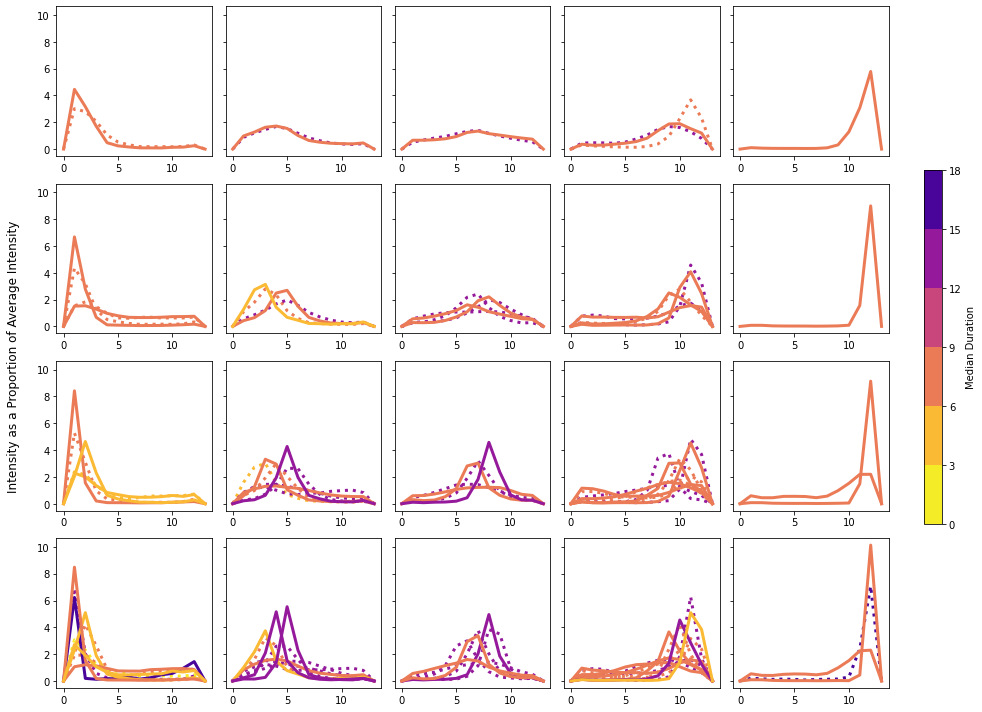

In [34]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Profiles is an array where rows are the dimensionless profiles
durations_for_profiles_ls = [top_10_percent_model_durations, top_10_percent_durations]
linestyles =['dotted', 'solid']

# Define hex color codes
hex_colors = ['#f3ec27', '#fbba33', '#eb7b56', '#c8467c', '#95199b', '#490499']

# Convert hex colors to RGBA format
rgba_colors = [mcolors.to_rgba(color) for color in hex_colors]
cmap = mcolors.ListedColormap(rgba_colors)

for number, profiles in enumerate([top_10_percent_model_profiles, top_10_percent_profiles]):
    durations_for_profiles = durations_for_profiles_ls[number]
    linestyle=linestyles[number]
    for num_clusters in [5, 10, 15, 20]:
        print(num_clusters)
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df = pd.DataFrame({'cluster_num': labels, 'duration': durations_for_profiles})
        df['duration'] = pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].median()

        for num, centroid_cumulative in enumerate(centroids):
            median_duration = df[df["cluster_num"] == num]['duration'].median()
            color = cmap(norm(median_duration))

            # Find portion which is heaviest
            heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0, len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity
            normalized_intensity = np.insert(normalized_intensity, 0, 0, axis=0)
            normalized_intensity = np.insert(normalized_intensity, 13, 0, axis=0)
            quintile_with_max_value = find_quintile_with_max_value(normalized_intensity)
            
            time_hours = np.array(range(0, len(centroid_cumulative)+1))

            if num_clusters == 5:
                axs[0, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 10:
                axs[1, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 15:
                axs[2, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3) 
            else:
                axs[3, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)

# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Median Duration')

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

## Classify and plot dimensionless profiles

### Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

5
10
15
20
25


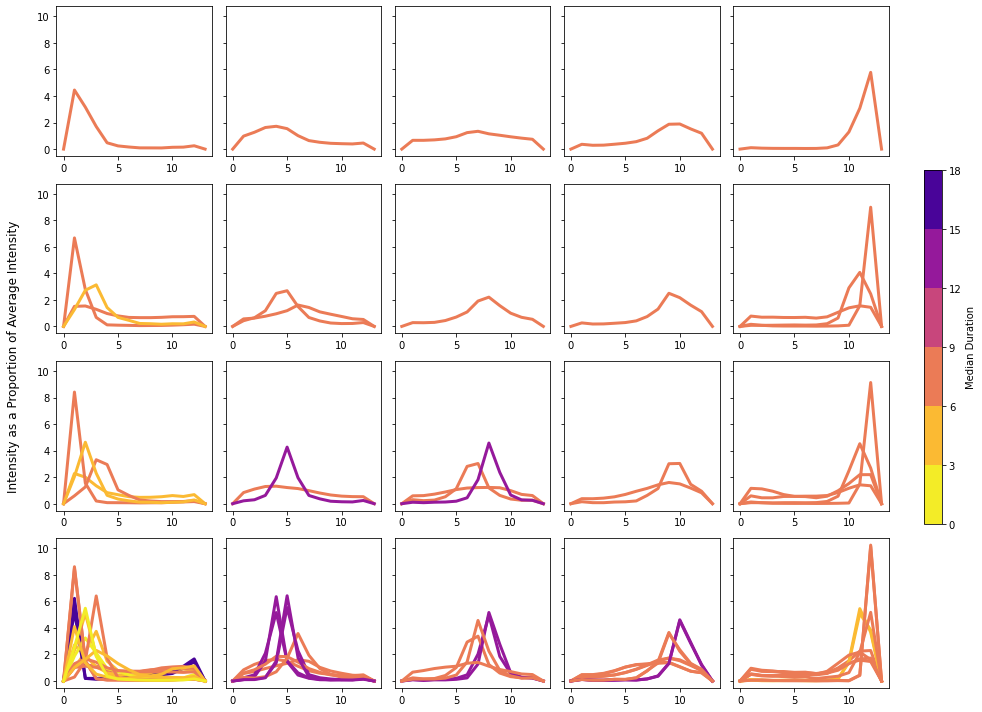

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import re
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles

durations_for_profiles_ls = [top_10_percent_durations]
boundaries = [0, 3, 6, 9, 12, 15, 18]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)
linestyles = ['solid', 'dotted']

# Define hex color codes
hex_colors = ['#f3ec27', '#fbba33', '#eb7b56', '#c8467c', '#95199b', '#490499']

# Convert hex colors to RGBA format
rgba_colors = [mcolors.to_rgba(color) for color in hex_colors]
cmap = mcolors.ListedColormap(rgba_colors)

for number, profiles in enumerate([top_10_percent_profiles]):
    linestyle = linestyles[number]
    durations_for_profiles = durations_for_profiles_ls[number]
    for num_clusters in [5, 10,15, 20, 25]:
        print(num_clusters)
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df = pd.DataFrame({'cluster_num': labels, 'duration': durations_for_profiles})
        df['duration'] = pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].median()

        for num, centroid_cumulative in enumerate(centroids):
            median_duration = df[df["cluster_num"] == num]['duration'].median()
            color = cmap(norm(median_duration))

            # Find portion which is heaviest
            heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0, len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity
            normalized_intensity = np.insert(normalized_intensity, 0, 0, axis=0)
            normalized_intensity = np.insert(normalized_intensity, 13, 0, axis=0)
            time_hours = np.array(range(0, len(centroid_cumulative)+1))

            if num_clusters == 5:
                axs[0, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 10:
                axs[1, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 15:
                axs[2, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3) 
            else:
                axs[3, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)

# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Median Duration')

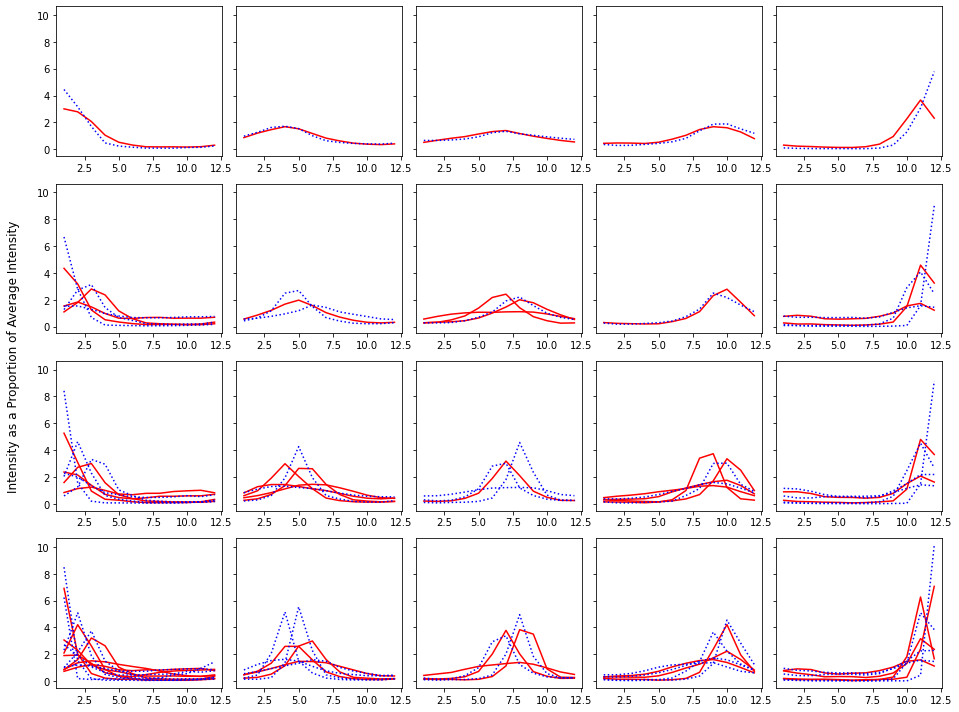

In [45]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles

durations_for_profiles_ls = [top_10_percent_model_durations, top_10_percent_durations]
linestyles =['solid', 'dotted']
colours = ['red','blue']
for number, profiles in enumerate([top_10_percent_model_profiles, top_10_percent_profiles]):
    color = colours[number]
    linestyle=linestyles[number]
    durations_for_profiles = durations_for_profiles_ls[number]
    for num_clusters in [5,10,15,20]:
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
        df['duration'] =  pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].mean()

        for num, centroid_cumulative in enumerate(centroids):

            # Find portion which is heaviest
            heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity


            if num_clusters ==5 :
                axs[0, quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==10:
                axs[1,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==15:
                axs[2,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle) 
            else:
                axs[3,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)  

    # Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

### Compare to the RVH profiles

In [46]:
# Read in profiles
rvh_profiles = pd.read_csv("../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'irain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']

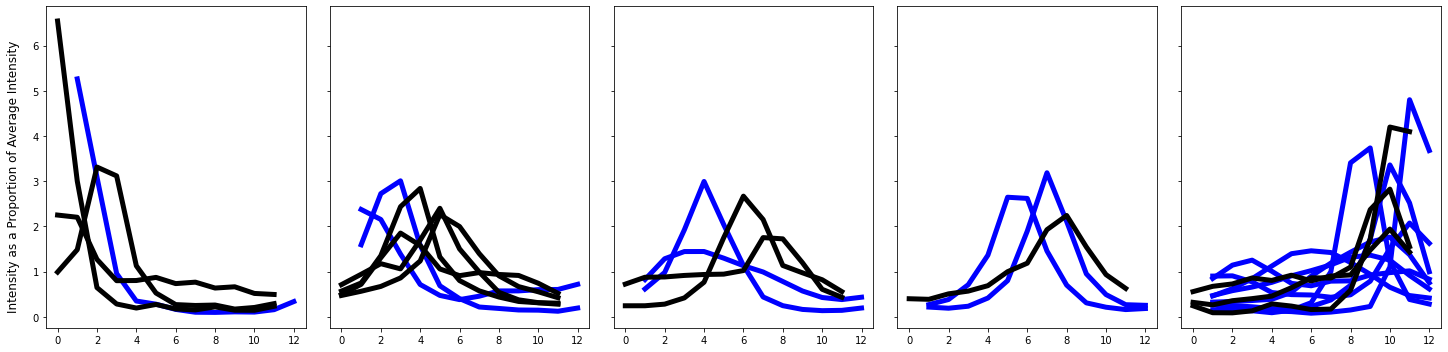

In [52]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles
num_clusters=15

# Create and fit the model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(top_10_percent_model_profiles)

# Get cluster labels for each profile
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

df= pd.DataFrame({'cluster_num':labels, 'duration':top_10_percent_model_durations})
df['duration'] =  pd.to_numeric(df['duration'])
df.groupby('cluster_num')['duration'].mean()

for num, centroid_cumulative in enumerate(centroids):

    # Find portion which is heaviest
    heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

    # Convert to intensity
    time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

    # Convert cumulative to intensity (mm/hour)
    intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

    # Calculate average intensity
    average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

    # Normalize intensity by average intensity
    normalized_intensity = intensity / average_intensity

    # plot
    axs[heaviest_segment].plot(time_hours[1:], normalized_intensity,
                              color='blue', linestyle='solid', linewidth=5) 

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
    axs[quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 5, color='black')   
        
# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()